In [291]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [273]:
df = pd.read_csv('./train.tsv', sep='\t')

In [274]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [275]:
df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [276]:
len(df)

156060

In [277]:
df = df.dropna()

In [278]:
df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

* Checking to see if any reviews are blank strings and not just NaN. 
* This means a review text could just be: "" or "  " or some other larger blank string.

In [279]:
s=" "
s.isspace()

True

In [280]:
df[df['Phrase'].str.isspace()]


,PhraseId,SentenceId,Phrase,Sentiment
2005,2006,76,,1


In [281]:
df = df[~df['Phrase'].str.isspace()]

In [282]:
df[df['Phrase'].apply(lambda review: review =='')]
# no empty strings
# can also use isin

,PhraseId,SentenceId,Phrase,Sentiment


In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156059 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156059 non-null  int64 
 1   SentenceId  156059 non-null  int64 
 2   Phrase      156059 non-null  object
 3   Sentiment   156059 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 6.0+ MB


**Confirm the value counts per label:**

In [285]:
df['Sentiment'].value_counts()

2    79582
3    32927
1    27272
4     9206
0     7072
Name: Sentiment, dtype: int64

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

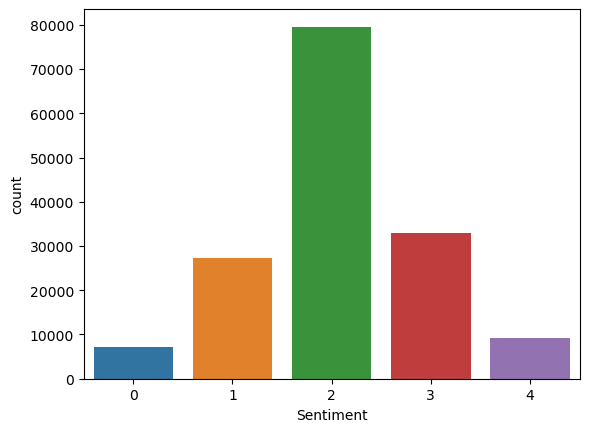

In [289]:
sns.countplot(x='Sentiment', data=df)

In [307]:
# df['Phrase_length'] = df['Phrase'].apply(len)
# fig = plt.figure(figsize=(8, 4))
# sns.boxplot(x='Sentiment', y='Phrase_length', data=df)

#### Training

In [45]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [69]:
def custom_tokenizer(text):
    # Tokenization
    tokens = text.split()
    
    # Remove stopwords, stem, and lemmatize the words
    processed_tokens = [
        stemmer.stem(token)
        for token in tokens
        if token.lower() not in stop_words
    ]
    token_string = " ".join(processed_tokens)
    
    # Return the processed tokens
    return token_string

In [70]:
df['phrase_custom'] = df['Phrase'].apply(custom_tokenizer)

In [72]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,phrase_custom
0,1,1,A series of escapades demonstrating the adage ...,1,seri escapad demonstr adag good goos also good...
1,2,1,A series of escapades demonstrating the adage ...,2,seri escapad demonstr adag good goos
2,3,1,A series,2,seri
3,4,1,A,2,
4,5,1,series,2,seri


In [47]:
from sklearn.model_selection import train_test_split

In [113]:
X = df['phrase_custom']
y=df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

### Training a Mode

**Creating a PipeLine that will both create a TF-IDF Vector out of the raw text data and fit a supervised learning model of our choice. Then fit that pipeline on the training data.**

In [114]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [115]:

import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mrizv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [249]:
linear_svc = LinearSVC()
pipe = Pipeline([('tfidf',TfidfVectorizer()),('svc',linear_svc)])


In [251]:
C = [0.5,0.52,0.54,0.56,0.58,0.6]
print(C)
param_grid = {'svc__C':C}

[0.5, 0.52, 0.54, 0.56, 0.58, 0.6]


In [252]:
grid_model = GridSearchCV(pipe,param_grid=param_grid,n_jobs=-1,scoring='accuracy',cv=10)

In [253]:
grid_model.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svc', LinearSVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.5, 0.52, 0.54, 0.56, 0.58, 0.6]},
             scoring='accuracy')

In [254]:
grid_model.best_params_

{'svc__C': 0.6}

In [269]:
import joblib
joblib.dump(grid_model,'grid.pkl')

['grid.pkl']

**TASK: Create a classification report and plot a confusion matrix based on the results of your PipeLine.**

In [262]:
from sklearn.metrics import classification_report, plot_confusion_matrix

In [264]:
preds = grid_model.predict(X_test)
preds

array([2, 0, 1, ..., 2, 3, 1], dtype=int64)

In [265]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.51      0.26      0.34      1417
           1       0.53      0.40      0.46      5472
           2       0.68      0.85      0.76     15878
           3       0.55      0.47      0.51      6640
           4       0.57      0.28      0.37      1805

    accuracy                           0.63     31212
   macro avg       0.57      0.45      0.49     31212
weighted avg       0.61      0.63      0.61     31212



c:\Users\mrizv\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


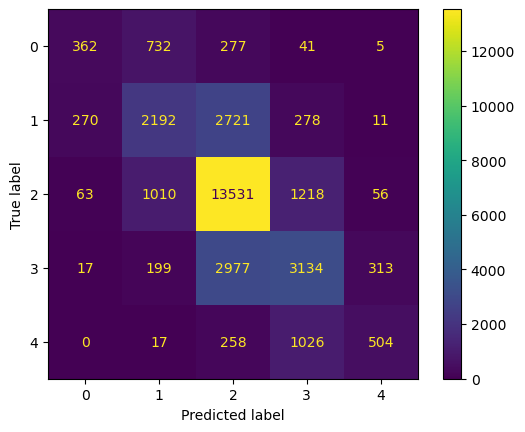

In [266]:
plot_confusion_matrix(grid_model,X_test,y_test)

In [268]:
# grid_model.predict(['Perfect movie ever, I love it and enjoyed a lot, I will recommend to everyone'])
X_test_custom=["excellent movie","nice","I don't know why people were so excited, It isn't worth it.","Time waste","Time pass","Time well spent",'Perfect movie ever, I love it and enjoyed a lot, I will recommend to everyone']
df = pd.DataFrame(X_test_custom,columns=['phrase'])
df['phrase_modified'] = df['phrase'].apply(custom_tokenizer)
df
grid_model.predict(df['phrase_modified'].values)

array([4, 3, 2, 1, 2, 3, 4], dtype=int64)

## The End